# Combined GNN Classifier

This notebook trains a single classifier to distinguish b vs c vs light-jets. Requires Python 3.9 and  "gnn_env" conda environment on sneezy. Skip to training performance to load training plots. If training is redone, manually update names for outputs (e.g. change outputs like full_bcq_model1.pth to full_bcq_model2.pth to prevent overwriting previous training).

* This notebook includes pT > 50 GeV
* Instead of processing data in this notebook, data is processed and saved as csv in "process_data.ipynb"
* Classes are labeled as:
    * b = 0
    * c = 1
    * q = 2
* Update names for saved model, training performance, etc for new runs to prevent overwriting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool, GraphConv
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [2]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Read from processed data
combined_df = pd.read_csv("combined_data.csv")

In [4]:
# Print number of events for each class in loaded file
combined_df['Class'].value_counts()

Class
0    1200000
1    1200000
2    1200000
Name: count, dtype: int64

In [5]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,weights,Class
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,1.000000,0
1,0.7844,-0.1852,-61.7426,0.0074,0.0073,0.0379,68.600578,167,0.783929,-0.185155,...,True,True,True,True,True,True,True,True,1.000000,0
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,False,1.000000,0
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,1.000000,0
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.799059,-0.161079,...,False,False,True,False,False,True,False,False,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599995,0.8250,-0.1694,-48.5565,0.0242,0.0221,0.1160,3.216820,13,0.874558,-0.185279,...,False,False,True,True,True,True,True,True,0.029919,2
3599996,0.8250,-0.1694,-48.5565,0.0242,0.0221,0.1160,3.216820,13,0.874558,-0.185279,...,False,False,True,True,True,True,True,True,0.029919,2
3599997,0.8250,-0.1694,-48.5565,0.0242,0.0221,0.1160,3.216820,13,0.874558,-0.185279,...,False,False,True,True,True,True,True,True,0.029919,2
3599998,0.8250,-0.1694,-48.5565,0.0242,0.0221,0.1160,3.216820,13,0.876224,-0.182653,...,True,False,True,True,True,True,True,False,0.029919,2


In [6]:
# Save df for each class before applying cuts
precut_b = combined_df[combined_df['Class'] == 0].reset_index(drop=True)
precut_c = combined_df[combined_df['Class'] == 1].reset_index(drop=True)
precut_q = combined_df[combined_df['Class'] == 2].reset_index(drop=True)

In [7]:
# Apply MC truth matching and cuts based on 'Class' value
combined_df = combined_df[
    ((combined_df['Class'] == 0) &
     (combined_df['Jet0_MC_Match'] == 1) &
     (combined_df['Jet0_MC_Jet_EfB'] > 0.6) &
     (combined_df['Jet0_PT'] > 20000) &
     (combined_df['Jet0_Eta'].between(2.2, 4.4))) |
    
    ((combined_df['Class'] == 1) &
     (combined_df['Jet0_MC_Match'] == 1) &
     (combined_df['Jet0_MC_Jet_EfD'] > 0.4) &
     (combined_df['Jet0_PT'] > 20000) &
     (combined_df['Jet0_Eta'].between(2.2, 4.4))) |
    
    ((combined_df['Class'] == 2) &
     (combined_df['Jet0_MC_Match'] == 1) &
     (combined_df['Jet0_MC_Jet_EfB'] < 0.2) &
     (combined_df['Jet0_MC_Jet_EfD'] < 0.2) &
     (combined_df['Jet0_PT'] > 20000) &
     (combined_df['Jet0_Eta'].between(2.2, 4.4)))
]

combined_df = combined_df.reset_index(drop=True)

In [8]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in combined_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

In [9]:
# Split data into training, validation, and test setsa
b_df = df[df['Class'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)
c_df = df[df['Class'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
q_df = df[df['Class'] == 2].sample(frac=1, random_state=42).reset_index(drop=True)

# Determine the minimum size among the classes for balanced training
min_size = min(len(b_df), len(c_df), len(q_df))

# Define training size (80% of the smallest class size)
train_size = int(0.8 * min_size)

# Define remaining size (20% of the smallest class size, split equally for validation and testing)
remaining_size = min_size - train_size
validation_size = remaining_size // 2
test_size = remaining_size // 2

# Create balanced training, validation, and testing sets
b_train = b_df.iloc[:train_size]
b_validation = b_df.iloc[train_size:train_size + validation_size]
b_test = b_df.iloc[train_size + validation_size:]

c_train = c_df.iloc[:train_size]
c_validation = c_df.iloc[train_size:train_size + validation_size]
c_test = c_df.iloc[train_size + validation_size:]

q_train = q_df.iloc[:train_size]
q_validation = q_df.iloc[train_size:train_size + validation_size]
q_test = q_df.iloc[train_size + validation_size:]

# Combine balanced sets
train_df = pd.concat([b_train, c_train, q_train]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([b_validation, c_validation, q_validation]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([b_test, c_test, q_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print sizes to confirm split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Testing set size: {len(test_df)}")

# Print class distributions to confirm balance
print(f"Training set class distribution:\n{train_df['Class'].value_counts()}")
print(f"Validation set class distribution:\n{validation_df['Class'].value_counts()}")
print(f"Testing set class distribution:\n{test_df['Class'].value_counts()}")

Training set size: 1020321
Validation set size: 127539
Testing set size: 199955
Training set class distribution:
Class
2    340107
0    340107
1    340107
Name: count, dtype: int64
Validation set class distribution:
Class
0    42513
1    42513
2    42513
Name: count, dtype: int64
Testing set class distribution:
Class
2    107099
0     50342
1     42514
Name: count, dtype: int64


In [10]:
print(train_df['Class'].value_counts() / len(train_df))
print(test_df['Class'].value_counts() / len(test_df))
print(validation_df['Class'].value_counts() / len(validation_df))

Class
2    0.333333
0    0.333333
1    0.333333
Name: count, dtype: float64
Class
2    0.535616
0    0.251767
1    0.212618
Name: count, dtype: float64
Class
0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64


In [11]:
# Calculate and print the efficiency for each class (b, c, and q)
print(f"Efficiency of b truth matching is: {len(b_df)/(len(precut_b)):.4f}")
print(f"Efficiency of c truth matching is: {len(c_df)/(len(precut_c)):.4f}")
print(f"Efficiency of q truth matching is: {len(q_df)/(len(precut_q)):.4f}")
print('')

# Print total events after truth matching and the number of events for each class
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b-jets after truth matching: {len(b_df)}")
print(f"Number of c-jets after truth matching: {len(c_df)}")
print(f"Number of q-jets after truth matching: {len(q_df)}")

Efficiency of b truth matching is: 0.3608
Efficiency of c truth matching is: 0.3543
Efficiency of q truth matching is: 0.4081

Total events after truth matching: 1347815
Number of b-jets after truth matching: 432962
Number of c-jets after truth matching: 425134
Number of q-jets after truth matching: 489719


Potentially useful to save information about training/ testing data for each run:

In [ ]:
# Open a file in write mode
with open("outputs_50/combined_data_stats3.txt", "w") as file:
    # Print sizes to confirm split
    file.write(f"Training set size: {len(train_df)}\n")
    file.write(f"Validation set size: {len(validation_df)}\n")
    file.write(f"Testing set size: {len(test_df)}\n\n")
    
    # Print class distributions to confirm balance
    file.write(f"Training set class distribution:\n{train_df['Class'].value_counts()}\n\n")
    file.write(f"Validation set class distribution:\n{validation_df['Class'].value_counts()}\n\n")
    file.write(f"Testing set class distribution:\n{test_df['Class'].value_counts()}\n\n")
    
    # Calculate and print the efficiency for each class (b, c, and q)
    file.write(f"Efficiency of b truth matching is: {len(b_df)/(len(precut_b)):.4f}\n")
    file.write(f"Efficiency of c truth matching is: {len(c_df)/(len(precut_c)):.4f}\n")
    file.write(f"Efficiency of q truth matching is: {len(q_df)/(len(precut_q)):.4f}\n\n")
    
    # Print total events after truth matching and the number of events for each class
    file.write(f"Total events after truth matching: {len(combined_df)}\n")
    file.write(f"Number of b-jets after truth matching: {len(b_df)}\n")
    file.write(f"Number of c-jets after truth matching: {len(c_df)}\n")
    file.write(f"Number of q-jets after truth matching: {len(q_df)}\n")

print("Output written to 'combined_data_stats3.txt'") # update name for new training

# Create Graphs
Jet-level features are duplicated to match number of daughters per event (since daughter features are stores as lists for each daughter). Graphs are constructed with one graph for each leading jet event. Each node within the graph corresponds to a daughter particle within that jet (different numebr of nodes per each graph). Each node has (already duplicated) jet-level features and daughter-level features. All nodes are connected to each other through edges wihtin the graphs.

In [12]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor([df['weights'].iloc[idx]], dtype=torch.float)

        y = torch.tensor([df['Class'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Classifier

Run this cell to use classifer to plot training performance:

In [28]:
# Define GNN architecture

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 3)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch, edge_weight):        
        x = self.conv1(x, edge_index, edge_weight)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index, edge_weight)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch, edge_weight)
        x = self.lin(x)
        
        return x

model = GNN()
model = model.to(device)

In [ ]:
# Define optimizer, loss function, and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss() # can be used for multiple classes
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs

# Training function
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        loss = criterion(out, data.y.long()) 
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            loss = criterion(out, data.y.long())
            pred = torch.argmax(out, dim=1)  # Get class with the highest probability
            correct = (pred == data.y).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    # Print outputs for each epoch
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Update csv outputs here! (model, training data)

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), 'outputs_50/combined_model3.pth')
        print('Model saved as outputs_50/combined_model3.pth.')

         # Save the loss and accuracy values to a CSV file, overwriting the existing file
        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('outputs_50/combined_training3.csv', index=False)
        print('Training results saved as outputs_50/combined_training3.csv.')

torch.save(model.state_dict(), 'outputs_50/combined_model3.pth')
print('Model saved as outputs_50/combined_model3.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file - update file names
results_df.to_csv('outputs_50/combined_training3.csv', index=False)
print('Training results saved as outputs_50/combined_training3.csv. Training complete.')

Epoch: 001, Train Loss: 0.9956, Test Loss: 0.9110, Train Acc: 0.5056, Test Acc: 0.5982
Epoch: 002, Train Loss: 0.9550, Test Loss: 0.9434, Train Acc: 0.5191, Test Acc: 0.5118
Epoch: 003, Train Loss: 0.9458, Test Loss: 0.9518, Train Acc: 0.5214, Test Acc: 0.4780
Epoch: 004, Train Loss: 0.9403, Test Loss: 0.9100, Train Acc: 0.5273, Test Acc: 0.5383
Epoch: 005, Train Loss: 0.9370, Test Loss: 0.8956, Train Acc: 0.5203, Test Acc: 0.5805
Epoch: 006, Train Loss: 0.9342, Test Loss: 0.9100, Train Acc: 0.5297, Test Acc: 0.5448
Epoch: 007, Train Loss: 0.9318, Test Loss: 0.9346, Train Acc: 0.5300, Test Acc: 0.5000
Epoch: 008, Train Loss: 0.9300, Test Loss: 0.9076, Train Acc: 0.5348, Test Acc: 0.5308
Epoch: 009, Train Loss: 0.9282, Test Loss: 0.8849, Train Acc: 0.5287, Test Acc: 0.5743
Epoch: 010, Train Loss: 0.9264, Test Loss: 0.9097, Train Acc: 0.5355, Test Acc: 0.5371
Epoch: 011, Train Loss: 0.9248, Test Loss: 0.9134, Train Acc: 0.5348, Test Acc: 0.5181
Epoch: 012, Train Loss: 0.9231, Test Loss: 

# Visualize training performance

In [33]:
# Reload training data to produce plots - can skip to here if training completed
training = pd.read_csv('outputs_50/combined_training2.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_37306/3550789103.py", line 2, in <module>
    training = pd.read_csv('outputs_50/combined_training2.csv')
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/pandas/io/parsers/readers.py", lin

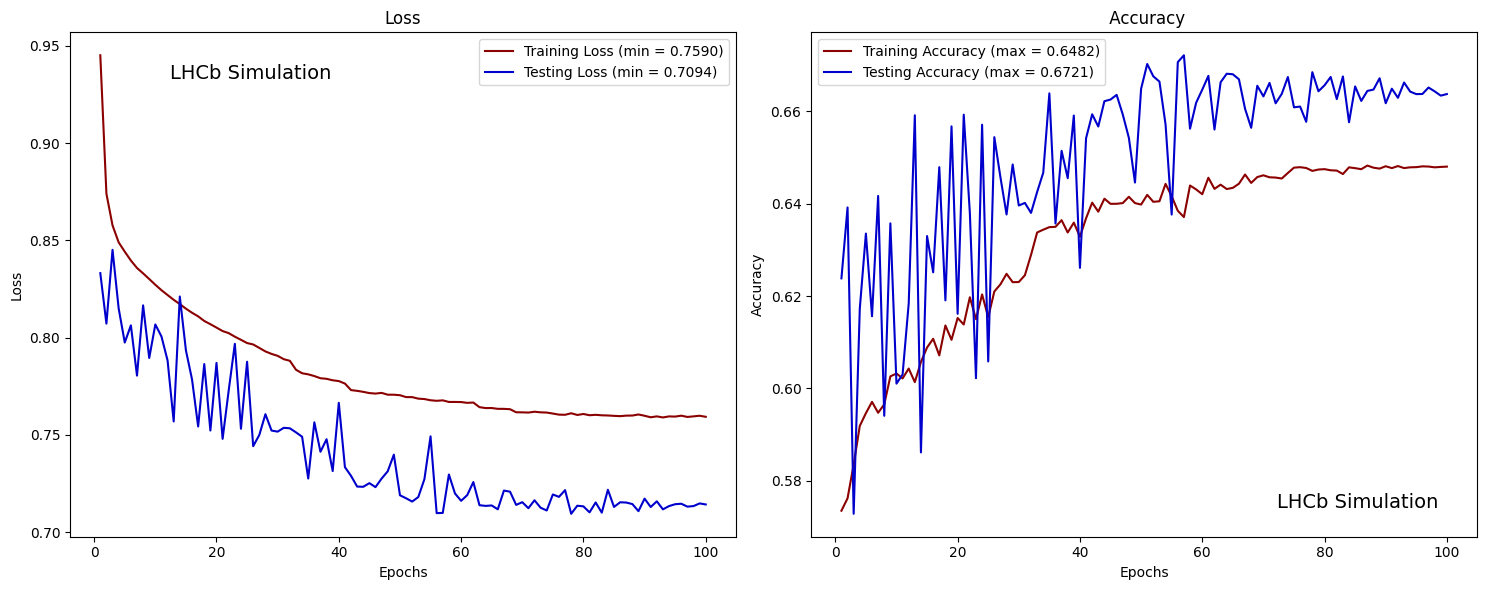

In [ ]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16) # optional title

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=14, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.05, "LHCb Simulation", transform=ax2.transAxes, fontsize=14, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.savefig('outputs_50/combined_loss_acc3.png', bbox_inches='tight')
    plt.show()
    
plot_training_results()

In [ ]:
# Get model predictions
y_true = []  # class values
y_scores = []  # predicted probabilities or scores

# Load model and switch to evaluation mode
model.load_state_dict(torch.load('combined_model1.pth'))
model = model.to('cpu')
model.eval()

with torch.no_grad():
    for data in test_loader:
        # Forward pass
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        prob = torch.softmax(out, dim=1)
        
        # Append true class labels and predicted probabilities
        y_true.append(data.y.numpy())
        y_scores.append(prob.numpy())  # Predicted probabilities for each class

# Concatenate the true labels and predicted probabilities
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# For the four combinations of classes, compute the ROC and AUC
combinations = [
    (0, 1),  # b vs c
    (0, 2),  # b vs q
    (1, 2),  # c vs q
    (0, 1, 2),  # bc vs q
]

for combo in combinations:
    if len(combo) == 2:  # Binary classification (b vs c, b vs q, c vs q)
        # Create combined true labels for the two selected classes
        combined_true = np.where(np.isin(y_true, combo), 1, 0)
        
        # Combine predicted probabilities for the selected two classes
        combined_scores = np.maximum(y_scores[:, combo[0]], y_scores[:, combo[1]])
        
        # Compute ROC and AUC
        fpr_combo, tpr_combo, _ = roc_curve(combined_true, combined_scores)
        roc_auc_combo = roc_auc_score(combined_true, combined_scores)
        
        # Store the results
        fpr[combo] = fpr_combo
        tpr[combo] = tpr_combo
        roc_auc[combo] = roc_auc_combo
    
    elif len(combo) == 3:  # Multi-class classification (bc vs q)
        # Create combined true labels for b and c vs q
        combined_true = np.where(np.isin(y_true, (0, 1)), 1, 0)  # 0 and 1 as positive class, 2 as negative
        
        # Combine predicted probabilities for bc vs q 
        combined_scores = np.maximum(y_scores[:, 0], y_scores[:, 1])  # Max probability between Class 0 (b) and 1 (c)
        
        # Compute ROC and AUC for the combined case
        fpr_combo, tpr_combo, _ = roc_curve(combined_true, combined_scores)
        roc_auc_combo = roc_auc_score(combined_true, combined_scores)
        
        # Store the results for the combined case
        fpr[combo] = fpr_combo
        tpr[combo] = tpr_combo
        roc_auc[combo] = roc_auc_combo

# Save the ROC and AUC results for each combination
np.save('outputs_50/combined_fpr_all_combinations.npy', fpr)
np.save('outputs_50/combined_tpr_all_combinations.npy', tpr)
np.save('outputs_50/combined_roc_auc_all_combinations.npy', roc_auc)

WIP: weird that bc vs q and b vs c are the exact same

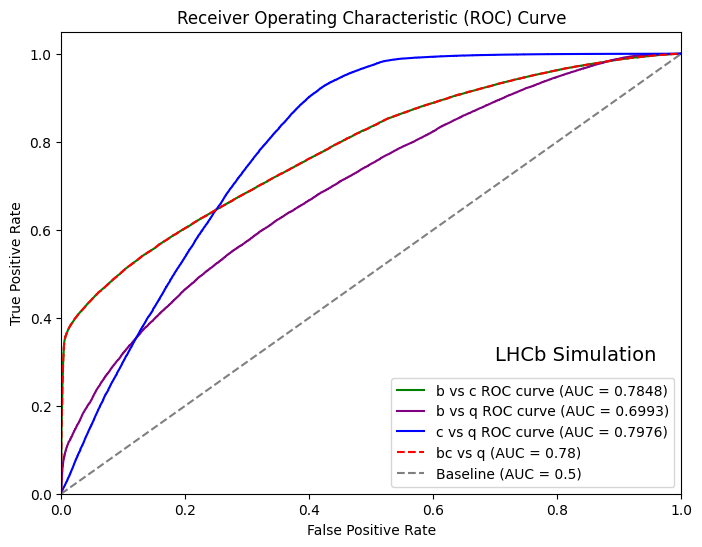

In [66]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr[(0, 1)], tpr[(0, 1)], color='green', label=f'b vs c ROC curve (AUC = {roc_auc[(0, 1)]:.4f})')
plt.plot(fpr[(0, 2)], tpr[(0, 2)], color='purple', label=f'b vs q ROC curve (AUC = {roc_auc[(0, 2)]:.4f})')
plt.plot(fpr[(1, 2)], tpr[(1, 2)], color='blue', label=f'c vs q ROC curve (AUC = {roc_auc[(1, 2)]:.4f})')
plt.plot(fpr[(0, 1, 2)], tpr[(0, 1, 2)], color='red', linestyle='--',label=f'bc vs q (AUC = {roc_auc[(0, 1, 2)]:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.text(0.7, 0.28, "LHCb Simulation", transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('outputs_50/combined_rocs2.png', bbox_inches='tight')
plt.show()

# Input random event and predict if it is b,c, or light

In [59]:
def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin', 'Jet0_SVtag_ptSvrJet', 'Jet0_SVtag_nTrk', 
                  'Jet0_SVtag_nTrkJet', 'Jet0_SVtag_drSvrJet', 'Jet0_SVtag_absQSum', 
                  'Jet0_SVtag_m', 'Jet0_SVtag_mCor', 'Jet0_SVtag_fdChi2', 'Jet0_SVtag_ipChi2Sum', 
                  'Jet0_SVtag_tau', 'Jet0_SVtag_z', 'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Process feature columns
    for col in feature_cols:
        if col in sample_jet.columns:
            sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * int(row['Jet0_nDaughters']) if isinstance(row[col], (float, int)) else row[col], axis=1)
            sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create a fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    # Make predictions
    for data in data_objects:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probabilities = F.softmax(out, dim=1) 
            predicted_classes = torch.argmax(probabilities, dim=1) # Get class with the highest probability for each node

            # Output the probabilities and predicted classes
            print(f'Probabilities: {probabilities.squeeze().tolist()}')
            print(f'Predicted Classes: {predicted_classes.tolist()}')

    return probabilities.squeeze().tolist()

# Loop to make 100 predictions
for i in range(100):
    make_predictions()

Probabilities: [0.1407254934310913, 0.5535227060317993, 0.3057517409324646]
Predicted Classes: [1]
Probabilities: [0.10618804395198822, 0.3638530373573303, 0.529958963394165]
Predicted Classes: [2]
Probabilities: [0.1865314245223999, 0.45664578676223755, 0.35682275891304016]
Predicted Classes: [1]
Probabilities: [0.12228572368621826, 0.22254227101802826, 0.6551720499992371]
Predicted Classes: [2]
Probabilities: [0.9831854701042175, 0.01617554947733879, 0.0006389822228811681]
Predicted Classes: [0]
Probabilities: [0.9967269897460938, 0.0028644271660596132, 0.00040863596950657666]
Predicted Classes: [0]
Probabilities: [0.1754271388053894, 0.5554954409599304, 0.269077330827713]
Predicted Classes: [1]
Probabilities: [0.2104390263557434, 0.3842792510986328, 0.40528178215026855]
Predicted Classes: [2]
Probabilities: [0.17976924777030945, 0.5271379947662354, 0.29309284687042236]
Predicted Classes: [1]
Probabilities: [0.4095829129219055, 0.2974241375923157, 0.2929929494857788]
Predicted Classe

# Create probability distributions

In [60]:
# Separate b and q data from testing dataset (preprocessed)
b = combined_df[combined_df.Class == 0]
c = combined_df[combined_df.Class == 1]
q = combined_df[combined_df.Class == 2]

b_data = create_graphs(b, feature_cols)
c_data = create_graphs(c, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
c_prob = []
q_prob = []

In [61]:
def get_probabilities(data_list, target_class):

    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            # Model forward pass
            out = model(data.x, data.edge_index, None, data.edge_weight)
            probabilities = F.softmax(out, dim=1) 
        
            # Append probabilities for the target class
            target_probs = probabilities[:, target_class].cpu().numpy()  # Extract probabilities for target class
            prob_list.extend(target_probs)
    
    return np.array(prob_list)

# Compute probabilities for b, c, and q data
b_prob = get_probabilities(b_data, target_class=0)
c_prob = get_probabilities(c_data, target_class=1)
q_prob = get_probabilities(q_data, target_class=2)

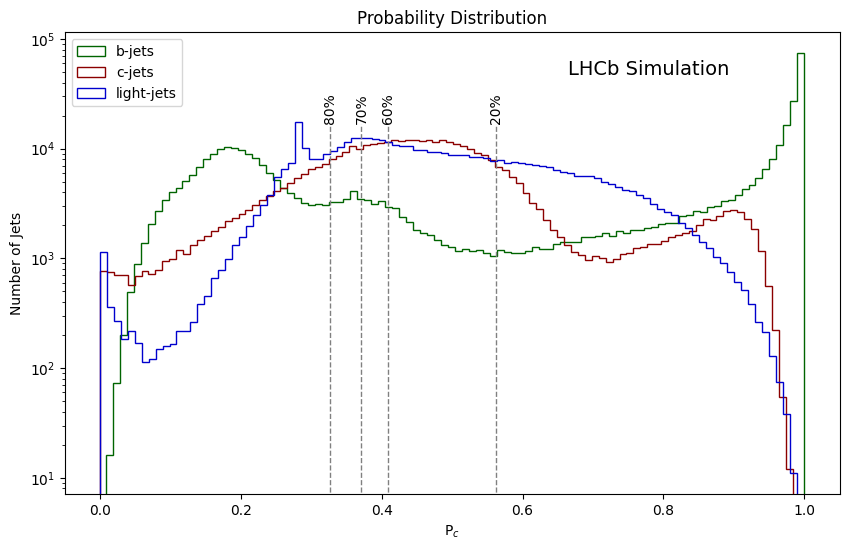

In [64]:
def plot_probability_distribution(c_prob, q_prob, target_efficiencies):

    # Sort c-jet probabilities in descending order for cutoff calculations
    sorted_c_prob = np.sort(c_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_c_prob) * efficiency)
        cutoffs[efficiency] = sorted_c_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_c_prob[0]
    
    # Plot histograms for c-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkgreen', histtype='step')
    c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='c-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='light-jets', color='mediumblue', histtype='step')

    max_y = max(max(c_values), max(q_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.95, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.95, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)

    plt.xlabel("P$_c$")
    plt.ylabel("Number of Jets")
    plt.text(0.65, 0.9, "LHCb Simulation", transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig('outputs_50/combined_probp3.png', bbox_inches='tight')
    plt.show()

target_efficiencies = [0.2, 0.6, 0.7, 0.8]
plot_probability_distribution(c_prob, q_prob, target_efficiencies)

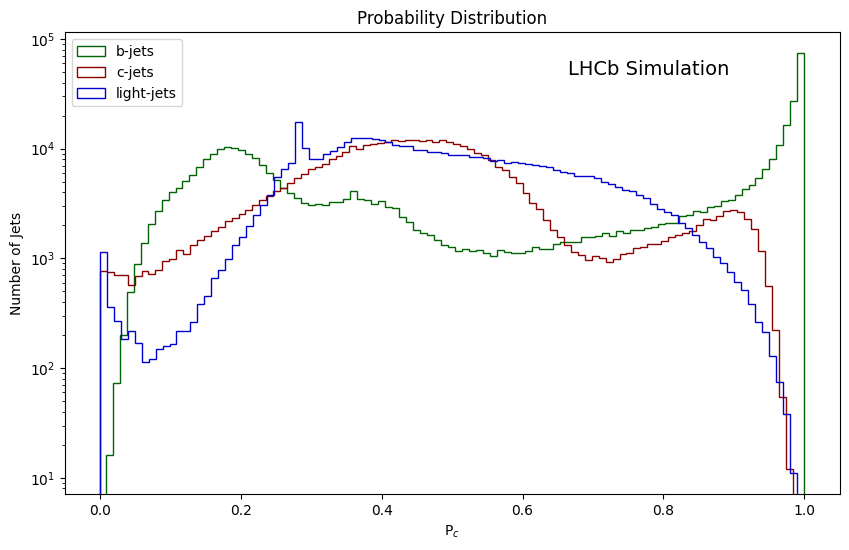

In [65]:
def plot_probability_distribution(c_prob, q_prob):

    # Sort c-jet probabilities in descending order for cutoff calculations
    sorted_c_prob = np.sort(c_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_c_prob) * efficiency)
        cutoffs[efficiency] = sorted_c_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_c_prob[0]
    
    # Plot histograms for c-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkgreen', histtype='step')
    c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='c-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='light-jets', color='mediumblue', histtype='step')

    plt.xlabel("P$_c$")
    plt.ylabel("Number of Jets")
    plt.text(0.65, 0.9, "LHCb Simulation", transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig('outputs_50/combined_prob3.png', bbox_inches='tight')
    plt.show()

plot_probability_distribution(c_prob, q_prob)